# ConvNet implementation

### Data Preprocessing

In [42]:
import os
import cv2
import numpy as np
from tqdm import tqdm # throw info during iteration

REBUILD_DATA = True # Change to True for generating the numpy file with the preprocessed data!

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    LABELS = {CATS:0, DOGS:1}
    training_data = []
    catcount = 0
    dogcount = 0
    errors = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)            
            for f in tqdm(os.listdir(label)): # iterate each file in the specific directory
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    self.errors += 1
                    #print(e) 
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print(f"Cats: {self.catcount}")
        print(f"Dogs: {self.dogcount}")
        print(f"Errors: {self.errors}")

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

kagglecatsanddogs_3367a/PetImages/Cat


100%|██████████| 12501/12501 [00:08<00:00, 1403.96it/s]


kagglecatsanddogs_3367a/PetImages/Dog


100%|██████████| 12501/12501 [00:09<00:00, 1310.88it/s]
c:\Users\adrian\Desktop\github-projects\dima\venv\lib\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Cats: 12476
Dogs: 12470
Errors: 56


### Loading preprocessed data 

In [43]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [13]:
print(len(training_data))

24946


In [14]:
print(training_data[0]) # image and label

[array([[174, 175, 178, ..., 245, 246, 245],
        [197, 193, 197, ..., 245, 246, 246],
        [188, 193, 204, ..., 245, 245, 245],
        ...,
        [196, 197, 202, ..., 229, 232, 231],
        [214, 199, 207, ..., 248, 224, 216],
        [249, 249, 248, ..., 249, 216, 216]], dtype=uint8) array([0., 1.])]


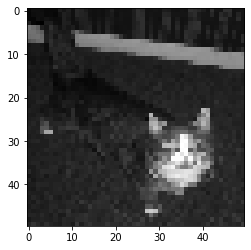

This is a CAT


In [20]:
import matplotlib.pyplot as plt 

N = 40
img = training_data[N,0]
ohe = training_data[N,1]
if ohe[0] == 1:
    label = "CAT"
else: 
    label = "DOG"

plt.imshow(img, cmap = 'gray')
plt.show()
print(f'This is a {label}')

In [57]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

class Net(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        self.fc1 = nn.Linear(2*2*128, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        #print(f'initial dim = {x.shape}')

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)

        #print(f'after first conv, dim = {x.shape}')

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        
        #print(f'after second conv, dim = {x.shape}')


        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)

        #print(f'after third conv, dim = {x.shape}')


        x = torch.flatten(x,1)
        
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        output = F.softmax(x, dim=1)
        
        return output

net = Net()



In [58]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X), len(test_X))

2494
22452 2494


In [61]:
BATCH_SIZE = 100
EPOCHS = 5

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 225/225 [00:21<00:00, 10.43it/s]


Epoch: 0. Loss: 0.1913282722234726


100%|██████████| 225/225 [00:21<00:00, 10.29it/s]


Epoch: 1. Loss: 0.17222529649734497


100%|██████████| 225/225 [00:24<00:00,  9.00it/s]


Epoch: 2. Loss: 0.16835466027259827


100%|██████████| 225/225 [00:24<00:00,  9.21it/s]


Epoch: 3. Loss: 0.14677074551582336


100%|██████████| 225/225 [00:24<00:00,  9.34it/s]

Epoch: 4. Loss: 0.12808190286159515


In [62]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:01<00:00, 1506.24it/s]

Accuracy:  0.747
